# Ejercicio 7 - guía 9

En el ajuste lineal del problema 4 graficar los datos sintéticos generados, el 90% HDI de 𝛽0 +𝛽1𝑥
para cada valor de 𝑥, y el el 90% HDI para las estimaciones de 𝑦.

### Desarrollo

Primero genero los datos sintéticos:

In [1]:
import numpy as np


# Estos son los años del 1 al 3
x = np.arange(1, 4)  

# Elijo arbitrariamente modelar a 30 estudiantes
cantidad_estudiantes = 30

# Digo que la taza de crecimiento sería de 3 cm por año
taza_crecimiento = 3

# y que la altura media de un estudiante es 160 cm 
altura_inicial = 160

# Simulo los datos con algo de ruido
y = altura_inicial + taza_crecimiento * x[:, None] + np.random.normal(0, 8, size=(3, cantidad_estudiantes))

Y ahora grafico los datos:

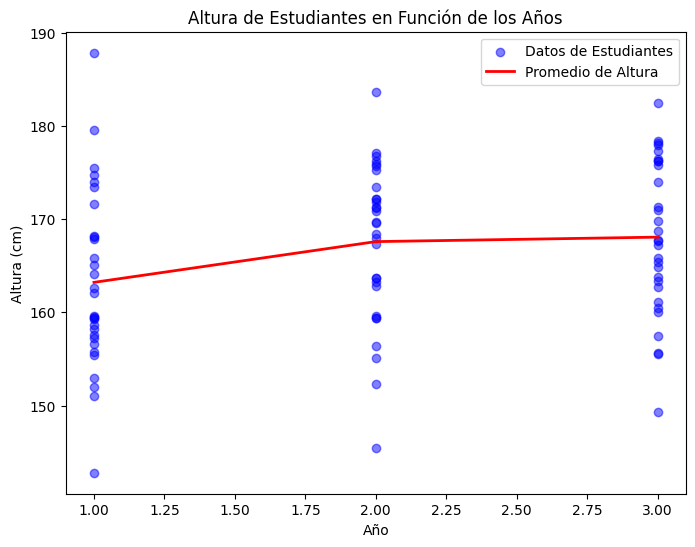

In [2]:
import matplotlib.pyplot as plt

# Graficar los puntos de datos
plt.figure(figsize=(8, 6))

for i in range(cantidad_estudiantes):
    plt.scatter(x, y[:, i], color="blue", alpha=0.5, label="Datos de Estudiantes" if i == 0 else "")

# Calcular el promedio de altura en cada año
y_mean = y.mean(axis=1)

# Graficar la línea de tendencia del promedio de altura en cada año
plt.plot(x, y_mean, color="red", label="Promedio de Altura", linewidth=2)

# Personalizar el gráfico
plt.xlabel("Año")
plt.ylabel("Altura (cm)")
plt.title("Altura de Estudiantes en Función de los Años")
plt.legend()
plt.show()

Ajusto un modelo en PyMC:

In [3]:
import pymc as pm

with pm.Model() as model:
    b0 = pm.Normal('b0', mu=160, sigma=20)
    b1 = pm.HalfNormal('b1', sigma=3)
    sigma = pm.HalfNormal('sigma', sigma=8)
    
    mu = b0 + b1 * x[:, None]
    
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,161.746,2.226,157.301,165.623,0.133,0.094,297.0,160.0,1.01
b1,2.269,1.006,0.338,4.018,0.058,0.046,318.0,264.0,1.01
sigma,8.862,0.675,7.581,10.111,0.019,0.014,1214.0,1200.0,1.00


<Figure size 800x500 with 0 Axes>

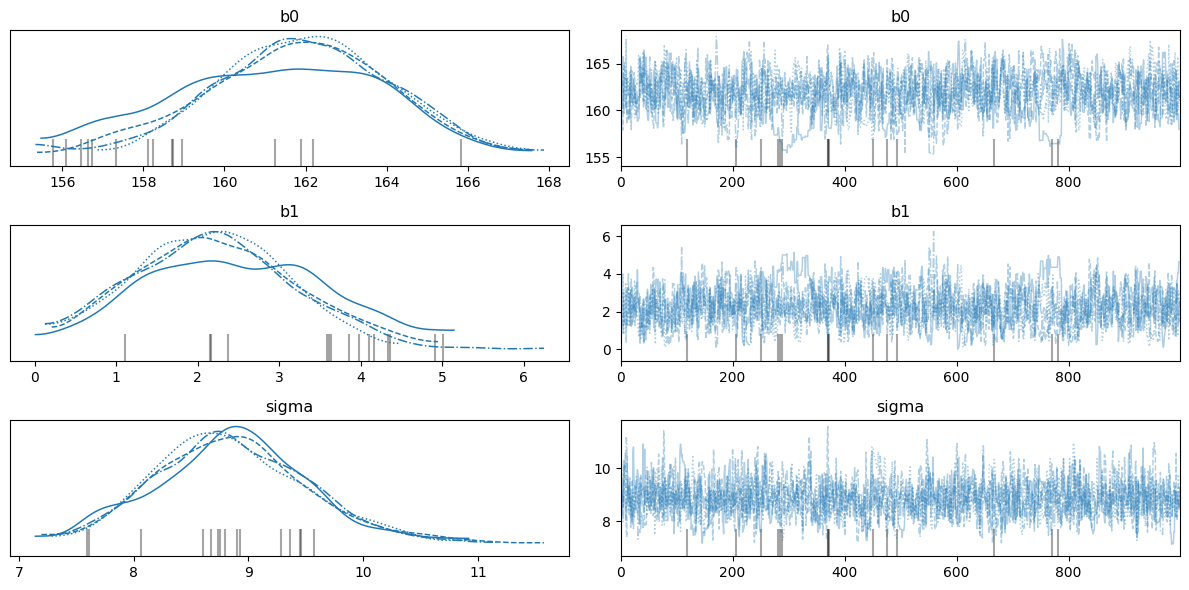

In [5]:
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

Grafico el 90% HDI del modelo para cada valor de 𝑥:

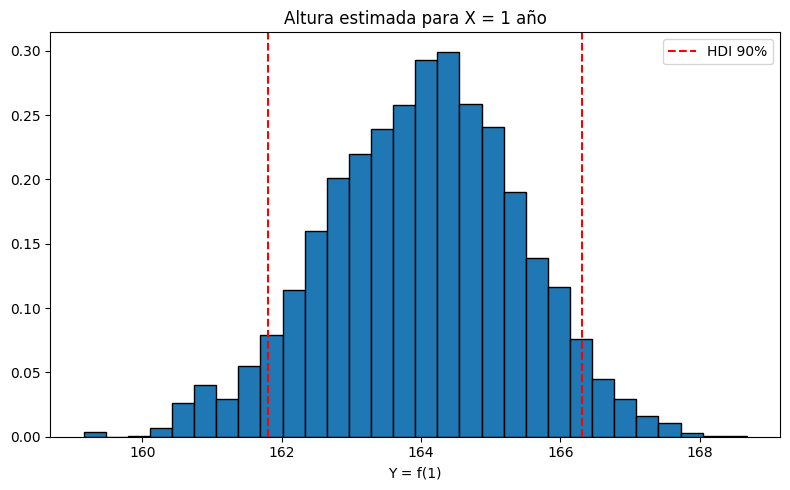

In [ ]:
import arviz as az

X_pred_1 = trace.posterior['b0'].values.flatten() + trace.posterior['b1'].values.flatten()*1
hdi_90_1 = az.hdi(X_pred_1, hdi_prob=0.9)

plt.figure(figsize=(8, 5))
plt.hist(X_pred_1, bins=30, density=True, edgecolor='black')
plt.axvline(hdi_90_1[0], color='red', linestyle='--', label='HDI 90%')
plt.axvline(hdi_90_1[1], color='red', linestyle='--')
plt.title('Altura estimada para X = 1 año')
plt.xlabel('Y = f(1)')
plt.legend()
plt.tight_layout()
plt.show()

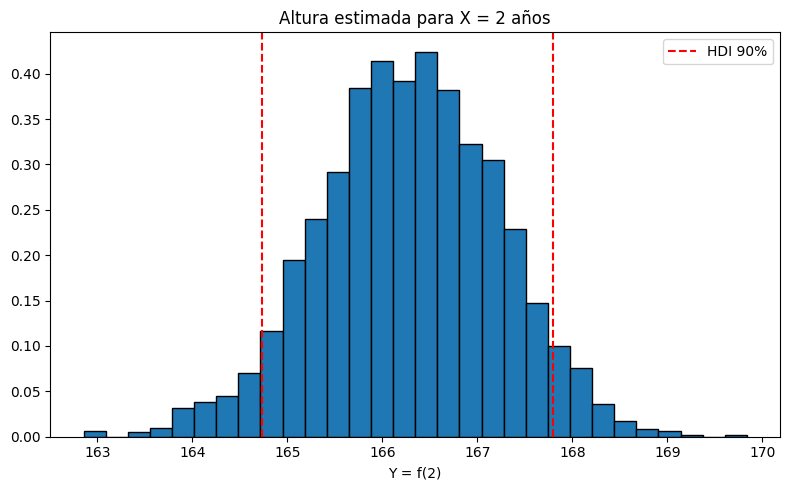

In [12]:
X_pred_2 = trace.posterior['b0'].values.flatten() + trace.posterior['b1'].values.flatten()*2
hdi_90_2 = az.hdi(X_pred_2, hdi_prob=0.9)

plt.figure(figsize=(8, 5))
plt.hist(X_pred_2, bins=30, density=True, edgecolor='black')
plt.axvline(hdi_90_2[0], color='red', linestyle='--', label='HDI 90%')
plt.axvline(hdi_90_2[1], color='red', linestyle='--')
plt.title('Altura estimada para X = 2 años')
plt.xlabel('Y = f(2)')
plt.tight_layout()
plt.legend()
plt.show()

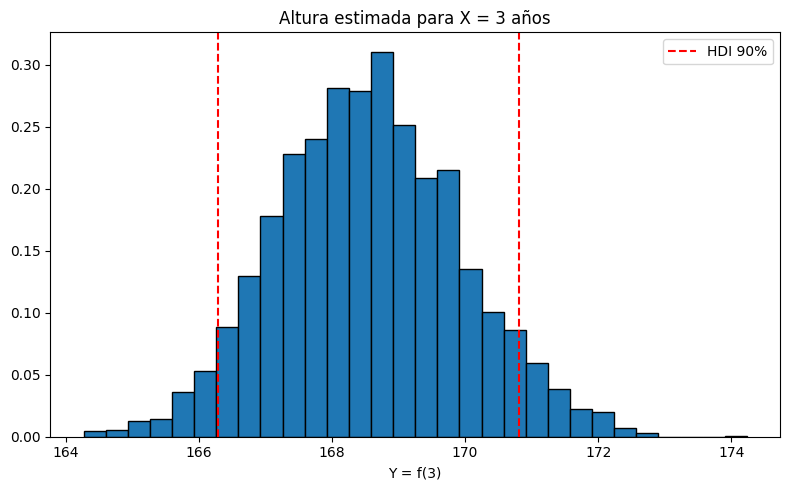

In [13]:
X_pred_3 = trace.posterior['b0'].values.flatten() + trace.posterior['b1'].values.flatten()*3
hdi_90_3 = az.hdi(X_pred_3, hdi_prob=0.9)

plt.figure(figsize=(8, 5))
plt.hist(X_pred_3, bins=30, density=True, edgecolor='black')
plt.axvline(hdi_90_3[0], color='red', linestyle='--', label='HDI 90%')
plt.axvline(hdi_90_3[1], color='red', linestyle='--')
plt.title('Altura estimada para X = 3 años')
plt.xlabel('Y = f(3)')
plt.tight_layout()
plt.legend()
plt.show()

Ahora obtengo las estimaciones de y para graficar su 90% HDI:

Sampling: [b0, b1, sigma, y_obs]
Sampling: [y_obs]


Output()

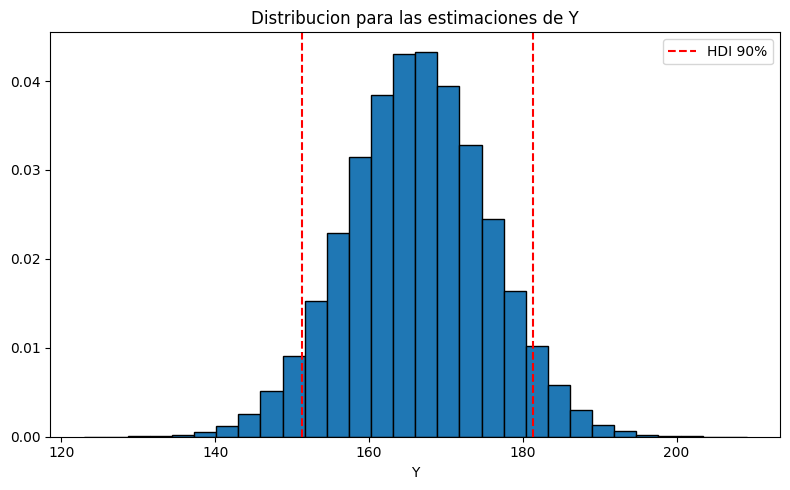

In [15]:
with model:
    trace.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    
estimaciones_y = trace.posterior_predictive['y_obs'].values.flatten()
hdi_90_y = az.hdi(estimaciones_y, hdi_prob=0.9)

plt.figure(figsize=(8, 5))
plt.hist(estimaciones_y, bins=30, density=True, edgecolor='black')
plt.title('Distribucion para las estimaciones de Y')
plt.axvline(hdi_90_y[0], color='red', linestyle='--', label='HDI 90%')
plt.axvline(hdi_90_y[1], color='red', linestyle='--')
plt.xlabel('Y')
plt.legend()
plt.tight_layout()
plt.show()